## Warning: This notebook is untested and running it fully may take a long time

In [17]:
import sys
#Change to own path
sys.path.insert(0, "/home/npatzlaff/Documents/rewiring-effects/")
from funcs.base import *
from tqdm import tqdm
import itertools
import pickle

#for sbi
import torch
import sbi
from sbi.inference.base import infer
from sbi.utils.get_nn_models import posterior_nn
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis as analysis

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Using SBI to find parameters consistent with specific dynamics

In [2]:
#Create prior

labels_params = ["EI_ratio", "mi_e", "mi_i", "E_H", "E_I"]
prior_min = [0.01, 0, 0, 0, 0]
prior_max = [1, 3, 40, 100, 100]

prior = sbi.utils.BoxUniform(low=prior_min, high=prior_max)

In [ ]:
#Sample parameters and run simulator
theta_sbi = []
x_sbi = []
t0 = time.time()
for i in tqdm(range(3000)):
    theta = prior.sample()
    x = sbi_simulator(theta)
    theta_sbi.append(theta)
    x_sbi.append(x)
#save results lest notebook crashes; change filename and path accordingly
with open("/home/npatzlaff/Documents/Inhibition_defines/results/SmallNet_theta_current-date", "wb") as handle:
        pickle.dump(theta_sbi, handle)
with open("/home/npatzlaff/Documents/Inhibition_defines/results/SmallNet_x_current-date", "wb") as handle:
        pickle.dump(x_sbi, handle)

In [ ]:
#Here's some I prepared earlier
with open("/home/npatzlaff/Documents/Inhibition_defines/results/SmallNet_theta_21-06-21", "rb") as handle:
        theta_sbi02 = pickle.load(handle)
with open("/home/npatzlaff/Documents/Inhibition_defines/results/SmallNet_x_21-06-21", "rb") as handle:
    x_sbi02 = pickle.load(handle)

In [ ]:
#Calculate statistics of results
x_stats = calc_stats(x_sbi02)
#save results
with open("/home/npatzlaff/Documents/Inhibition_defines/results/SmallNet_x-stats_current-date", "wb") as handle:
        pickle.dump(x_stats, handle)

tensor([1.3150e+01, 2.3260e+02, 1.2806e+01, 2.3757e+02, 8.2109e-01, 8.3286e-01,
        9.4855e-02, 1.1363e-01])


(1000000.0, 2500000.0)

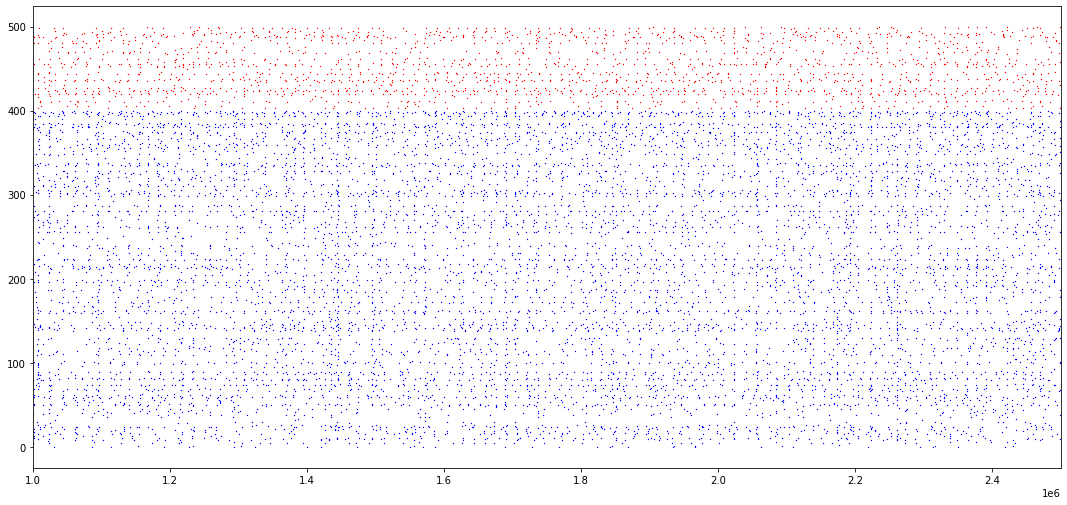

In [5]:
#Example usage and raster plot

true_params = np.array([0.2, 1, 19.5, 30, 30])

#Note that calc_stats normally takes list of results; here: 1-element list
true_res = [sbi_simulator(true_params)]
obs = calc_stats(true_res)[0]
print(obs)

i_e = true_res[0][0]
t_e = true_res[0][1]
i_i = true_res[0][2]
t_i = true_res[0][3]
i_i_m  = i_i + int(500-true_params[0]*500)


fig,axes = plt.subplots(figsize=(15, 7))
fig.tight_layout() 
rcParams['axes.labelsize'] = 17
rcParams['axes.titlesize'] = 17


plot(t_e/ms, i_e, 'b*', ms=0.8)
plot(t_i/ms, i_i_m, 'r*', ms=0.8 )
plt.xlim([1e6, 2.5e6])

In [ ]:
#Train posterior

larger_nn = posterior_nn(model='maf', hidden_features=80, num_transforms=40)
inference = SNPE(prior=prior, density_estimator=larger_nn)

density_estimator = inference.append_simulations(torch.cat(theta_sbi02).reshape(3000, 5), x_stats).train()
posterior = inference.build_posterior(density_estimator)  # MCMC kwargs go here.

with open("/home/npatzlaff/Documents/Inhibition_defines/results/SmallNet_posterior_current-date.pkl", "wb") as handle:
        pickle.dump(posterior, handle)

In [6]:
#Here's one i prepared
with open("/home/npatzlaff/Documents/Inhibition_defines/results/SmallNet_posterior_21-06-24.pkl", "rb") as handle:
        posterior02 = pickle.load(handle)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

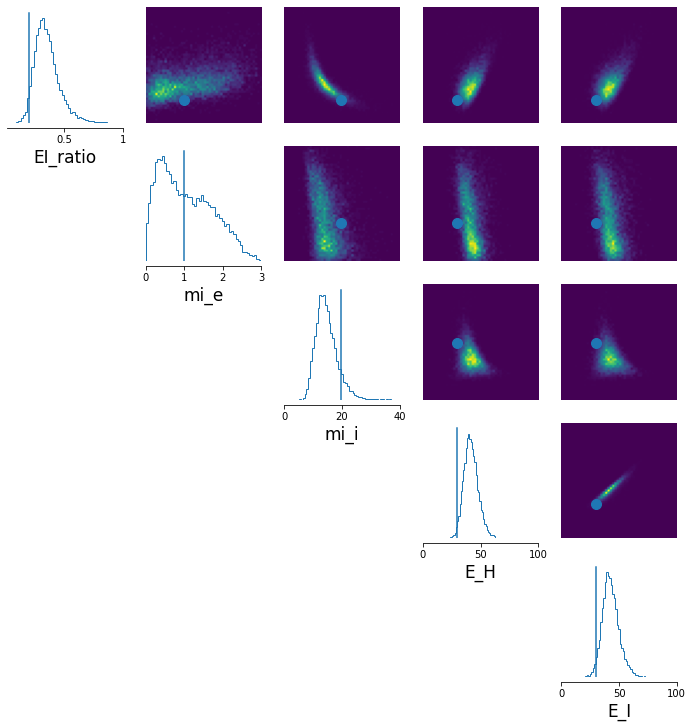

In [10]:
#sample from posterior and use built-in function to plot best estimates for observation above

prior_lims = np.concatenate((np.asarray(prior_min).reshape(-1,1),np.asarray(prior_max).reshape(-1,1)),axis=1)

samples = posterior02.sample((10000,), x=obs)
log_probability = posterior02.log_prob(samples, x=obs)
pplot = analysis.pairplot(samples, limits=prior_lims, figsize=(12,12), labels=labels_params, points=true_params)

In [ ]:
#Randomly draw parameters and calculate median absolute errors to validate fit
#Median to reduce impact of outliers, absolute to not deflate error in CV and K
n_runs = 20
mses = np.zeros((n_runs,8))
mses_samethetas = np.zeros((n_runs, 8))

validate_thetas = []
validate_stats = []
validate_params = []
validate_ress = []

for i in range(n_runs):
    #Sample random params
    temp_theta = prior.sample()
    #Get target results
    temp_x = simulator(temp_theta)
    temp_stats = calc_stats([temp_x])
    #Get best estimate of parameters from sbi
    temp_params = posterior02.map(x=temp_stats, num_iter=100, 
                                   learning_rate=0.01, num_init_samples=1000, num_to_optimize=100, 
                                   save_best_every=50, show_progress_bars=False)
    #Results with best param estimate
    temp_res = calc_stats([simulator(temp_params)])
    
    #Add all to list for later saving
    validate_thetas.append(temp_theta)
    validate_stats.append(temp_stats)
    validate_params.append(temp_params)
    validate_ress.append(temp_res)
    
    #Calculate squared error
    temp_mse = (temp_stats - temp_res)**2
    mses[i,:] = temp_mse
    
    #Calculate squared error with identical params
    temp_stats02 = calc_stats([simulator(temp_theta)])
    temp_mse02 = (temp_stats - temp_stats02)**2
    mses_samethetas[i,:] = temp_mse02
#Take sqrt to make absolute error
sqrt_full_mses = np.sqrt(full_mses)
sqrt_full_mses_samethetas = np.sqrt(full_mses_samethetas)

In [14]:
#Here's some of mine
full_mses = np.zeros((100, 8))
full_mses_samethetas = np.zeros((100, 8))

for i in range(4):
    full_mses[i*20:(i+1)*20,:] = np.load("/home/npatzlaff/Documents/Inhibition_defines/results/SmallNet_random-check_val-mses_run0%s.npy" %str(i+1))
    full_mses_samethetas[i*20:(i+1)*20,:] = np.load("/home/npatzlaff/Documents/Inhibition_defines/results/SmallNet_random-check_val-mses-sameThetas_run0%s.npy" %str(i+1))
#Take sqrt; square would deflate errors of CV and K
sqrt_full_mses = np.sqrt(full_mses)
sqrt_full_mses_samethetas = np.sqrt(full_mses_samethetas)

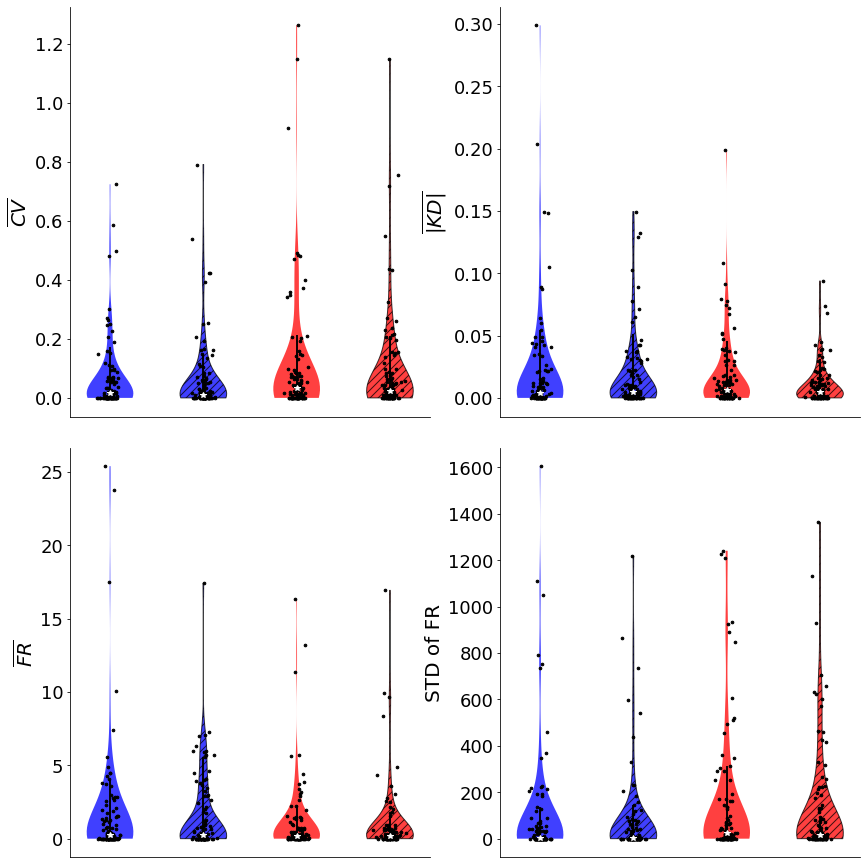

In [16]:
scaling=3

#From Stackoverflow; used to get whiskers
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


fig, axes = plt.subplots(2,2, figsize=(11.69/3*scaling, 16.54/4*scaling))
plt.tight_layout( w_pad=4, h_pad=1)
plt.rcParams['axes.labelsize'] = 20

#Reorder for plotting
stat_pairs = [(6,7), (1,3), (4,5), (0,2)]
stat_labels = ["$\overline{|KD|}$", "STD of FR", "$\overline{CV}$", "$\overline{FR}$"]

#Get quartiles and median
quartile1_mses, medians_mses, quartile3_mses = np.percentile(sqrt_full_mses, [25, 50, 75], axis=0)
quartile1_mses_samethetas, medians_mses_samethetas, quartile3_mses_samethetas = np.percentile(sqrt_full_mses_samethetas, [25, 50, 75], axis=0)

#From stackoverflow
whiskers_mses = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(np.sort(sqrt_full_mses), quartile1_mses, quartile3_mses)])
whiskers_min_mses, whiskers_max_mses = whiskers_mses[:, 0], whiskers_mses[:, 1]
whiskers_mses_samethetas = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(np.sort(sqrt_full_mses_samethetas), quartile1_mses_samethetas, quartile3_mses_samethetas)])
whiskers_min_mses_samethetas, whiskers_max_mses_samethetas = whiskers_mses_samethetas[:, 0], whiskers_mses_samethetas[:, 1]


#Plotting params
colours = ["b", "b", "r", "r"]
#scatter plot params
g_scale = 0.05
s_color="k"
s_marker="o"
s_s=7

#For each stat
for i in range(4):
    #Get indices of relevant stats
    idx = stat_pairs[i]
    #Lower whiskers
    w_min = [whiskers_min_mses[idx[0]], whiskers_min_mses_samethetas[idx[0]], whiskers_min_mses[idx[1]], whiskers_min_mses_samethetas[idx[1]]]
    #Upper whiskers
    w_max = [whiskers_max_mses[idx[0]], whiskers_max_mses_samethetas[idx[0]], whiskers_max_mses[idx[1]], whiskers_max_mses_samethetas[idx[1]]]
    #Draw violinplot at subplot
    vp = axes[i%2][int(i<2)].violinplot([sqrt_full_mses[:,idx[0]], sqrt_full_mses_samethetas[:,idx[0]], sqrt_full_mses[:,idx[1]], sqrt_full_mses_samethetas[:,idx[1]]], 
                                        showextrema=False, showmedians=False, showmeans=False)
    #Set vp body params
    for ii,pc in enumerate(vp["bodies"]):
        if ii%2 == 0:
            #For optimal parameters
            pc.set_facecolor(colours[ii])
        else:
            #For same parameters
            pc.set_edgecolor("k")
            pc.set_facecolor(colours[ii])
            pc.set_hatch("///")
        pc.set_alpha(0.75)
    axes[i%2][int(i<2)].set_ylabel(stat_labels[i])
    #Medians
    axes[i%2][int(i<2)].plot([1,2,3,4], [medians_mses[idx[0]], medians_mses_samethetas[idx[0]], medians_mses[idx[1]], medians_mses_samethetas[idx[1]]],
                             "*", color="white")
    #Whiskers
    axes[i%2][int(i<2)].vlines([1,2,3,4], w_min, w_max, color='k', linestyle='-', lw=1.5)
    axes[i%2][int(i<2)].vlines([1,2,3,4], w_min, w_max, color='k', linestyle='-', lw=1.5)
    
    #Scatter-plot of full values
    axes[i%2][int(i<2)].scatter(np.ones(len(sqrt_full_mses[:,idx[0]]))+np.random.normal(scale=g_scale, size=len(sqrt_full_mses[:,idx[0]])), 
                    sqrt_full_mses[:,idx[0]], color=s_color, marker=s_marker, s=s_s)
    axes[i%2][int(i<2)].scatter(np.ones(len(sqrt_full_mses_samethetas[:,idx[0]]))*2+np.random.normal(scale=g_scale, size=len(sqrt_full_mses[:,idx[0]])), 
                    sqrt_full_mses_samethetas[:,idx[0]], color=s_color, marker=s_marker, s=s_s)
    
    axes[i%2][int(i<2)].scatter(np.ones(len(sqrt_full_mses[:,idx[1]]))*3+np.random.normal(scale=g_scale, size=len(sqrt_full_mses[:,idx[1]])), 
                    sqrt_full_mses[:,idx[1]], color=s_color, marker=s_marker, s=s_s)
    axes[i%2][int(i<2)].scatter(np.ones(len(sqrt_full_mses_samethetas[:,idx[1]]))*4+np.random.normal(scale=g_scale, size=len(sqrt_full_mses_samethetas[:,idx[1]])), 
                    sqrt_full_mses_samethetas[:,idx[1]], color=s_color, marker=s_marker, s=s_s)
    
    axes[i%2][int(i<2)].set_xticks([])
    for tick in axes[i%2][int(i<2)].yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
sns.despine()

In [ ]:
#From Oleg
scaling=0.72
param_labels = [r"$\rho$", "$\mu_E$ [mV]", "$\mu_I$ [mV]", "$I_E$ [mV]", "$I_I$ [mV]"]
plot_prior_min = [0, 0, 0, 0, 0]
plot_prior_max = [1, 3, 40, 100, 100]
import itertools
from tqdm import tqdm

combs = list(itertools.combinations([0,1,2,3,4],2))
axis_combs = [(3,4), (2,4), (1,4), (0,4),
           (2,3), (1,3), (0,3),
           (1,2), (0,2), 
           (0,1)]

T = np.tril_indices_from(np.eye(5), k=-1)
fig, axes = plt.subplots(5,5, figsize=(11.69*scaling, 11.69*scaling))
plt.tight_layout( w_pad=1, h_pad=2.2)
plt.rcParams['axes.labelsize'] = 20

for i in range(len(T[0])):
    axes[T[0][i],T[1][i]].set_visible(False)

c_shift=6
colors = sns.color_palette('spring',n_colors=len(all_samples)+c_shift)
colors=colors[c_shift:]

idx=0
for comb in tqdm(combs):
    for i, sample in enumerate(all_samples):
        if i%2==0:
            sns.kdeplot(x=sample[:,comb[0]], y=sample[:,comb[1]],
                ax=axes[axis_combs[idx]],thresh=0.05, levels=1,
                        color=colors[i],fill=0,shade =False, 
                       )
    
    
    axes[axis_combs[idx]].set_yticks([plot_prior_min[comb[1]], plot_prior_max[comb[1]]])
    axes[axis_combs[idx]].set_xticks([plot_prior_min[comb[0]], plot_prior_max[comb[0]]])
    sns.despine(ax=axes[axis_combs[idx]])
    idx=idx+1

ax_idc = np.flip(np.arange(len(param_labels)))
for i in tqdm(np.arange(len(param_labels))):
    idx =ax_idc[i]
    for n,sample in enumerate(all_samples):
        if n%2==0:
            sns.kdeplot(sample[:,i],ax=axes[idx,idx],
                        color=colors[n])
    axes[idx,idx].set_xlabel(param_labels[i], fontsize=20)

    if i == 3:
        axes[i,i].set_xticks([0,3])
    if i == 2:
        axes[i,i].set_xticks([0,20,40])
    for tick in axes[i,i].xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in axes[i,i].yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
for n,sample in enumerate(all_samples):
    if n%2==0:
        axes[2,1].plot(1.,1,'-',color=colors[n],label ='$\overline{FR}_I$=%s Hz'%fr_range[n], linewidth=2);
axes[2,1].set_xlim([10,12])
axes[2,1].legend(frameon=False, handletextpad=0.5, labelspacing=0.2, handlelength=1, fontsize=18)
axes[2,1].set_visible(True)
axes[2,1].set_yticks([])
axes[2,1].set_xticks([])
sns.despine(left=True,bottom=True,ax=axes[2,1])
axes[4,4].axvline(0.2, c="grey", ls="--")
plt.show()